In [1]:
# pip install pysd
%pylab inline
import pysd
import pandas as pd
import random
import numpy as np
model = pysd.load('./slap_the_bass.py')

Populating the interactive namespace from numpy and matplotlib


In [2]:
model.doc()

,Real Name,Py Name,Unit,Lims,Type,Eqn,Comment
0,AdEffectness1,ad_effectness_1,b'dmnl',"(None, None)",constant,b'0.011',b''
1,AdEffectness2,ad_effectness_2,b'dmnl',"(None, None)",constant,b'0.011',b''
2,Adopters1,adopters_1,b'person',"(0, total population)",component,"b'INTEG(adoption rate 1, 0)'",b''
3,Adopters2,adopters_2,b'person',"(0, total population)",component,"b'INTEG(adoption rate 2, 0)'",b''
4,Adoption rate 1,adoption_rate_1,b'person/Month',"(None, None)",component,b'adoption from AD 1 + adoption from WOM 1',b''
5,Adoption rate 2,adoption_rate_2,b'person/Month',"(None, None)",component,b'adoption from AD 2 + adoption from WOM 2',b''
6,Chaotic rate 1,chaotic_rate_1,b'person/contact',"(0, 1)",variable,b'0.3',b'aka P11'
7,Chaotic rate 2,chaotic_rate_2,b'person/contact',"(0, 1)",variable,b'0.4',b'aka P21'
8,Competitive rate 1,competitive_rate_1,b'person/Month',"(None, None)",component,b'tolerance_rate_1 * wom_effectness_2 * contac...,b''
9,Competitive rate 2,competitive_rate_2,b'person/Month',"(None, None)",component,b'tolerance_rate_2 * wom_effectness_1 * contac...,b''


Визуализация начальных условий. Поменял год на месяц для большей реалистичности, а то окажется, что мы существуем в типичной математической задаче) 

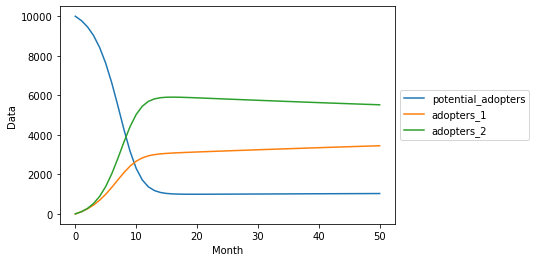

In [3]:
model = pysd.load('./slap_the_bass.py')
values = model.run(return_columns=['potential_adopters', 'adopters_1', 'adopters_2'])
values.plot()
plt.ylabel('Data')
plt.xlabel('Month')
plt.legend(loc='center left', bbox_to_anchor=(1,.5));

Итак, базовая модель реализована, теперь перейдем к сходимости модели. У нас существуют по сути 2 варианта сходимости:
1. Стационарное состояние 
2. И нестационарное состояние (периодическое состояние или хаос)

Для первого варианта под сходимостью обозначим ситуацию, когда контейнеры с клиентами изменяются совсем незначительно за единицу времени.

Для второго состояния, поскольку мы не рассматриваем вариант хаоса, будем оценивать сходимость как наблюдение одного и того же состояния контейнера через равные интервалы времени. 

Для получение первого и второго состояния будем варьировать параметры в соответствии с ограничениями.

$$
\text { Constraints: }\left\{\begin{array}{l}
0 \leqslant p_{11}+p_{13} \leqslant 1 \\
0 \leqslant p_{21}+p_{23} \leqslant 1 \\
p_{i j} \in[0 ; 1] \forall i, j \in\{1,2,3\}
\end{array}\right.
$$

Начнем со сходимости в стационарном решении. Под сходимостью будем понимать ситуацию, когда все отношения:
1. adopters_1 / potential_adopters
2. adopters_2 / potential_adopters
3. adopters_1 / adopters_2


На текущем шаге по отношению к предыдущему изменились не более, чем на 0.01%. В таком случае мы будем считать, что сходимость существует. Под точкой сходимости будем понимать точку, когда впервые указанное условие соблюдено.

Здесь же реализуем алгоритм поиска периодического решения. Его искать на i-м шаге будем на основании первых двух отношений. Если абсолюная разница между несколькими последовательными шагами до i-го момента и после него не превышает некоторого eps (в нашем случае достаточно большого), а также знаки в такой последовательности постоянно меняются с каждым шагом на противоположный, то мы нашли переодичкое решение. Такое решение будем искать только после того, как мы не нашли стационарного решения. 

In [4]:
def find_periodic(change):
    periodic_point = -1
    interval = 20
    eps = 30
    
    minus_to_plus = np.array([-1 if x%2==0 else 1 for x in range(interval)])

    for i in range(interval+2, len(change)-interval):
        last_1 = np.round(change.ratio_1_to_pot.iloc[i-interval:i].values, 3)
        next_1 = np.round(change.ratio_1_to_pot.iloc[i:i+interval].values, 3)
        last_2 = np.round(change.ratio_2_to_pot.iloc[i-interval:i].values, 3)
        next_2 = np.round(change.ratio_2_to_pot.iloc[i:i+interval].values, 3)
        if (all(abs(last_1 - next_1) < eps) or all(abs(last_2 - next_2) < eps)) \
        and (all(np.sign(last_1) == minus_to_plus) or all(np.sign(last_1) != minus_to_plus) \
             or all(np.sign(last_2) == minus_to_plus) or all(np.sign(last_2) != minus_to_plus)):
            periodic_point = change.iloc[[i-interval]].index[0]
            
    if periodic_point==-1:
        print('Периодическое решение также не найдено на заданном интервале')
    else:
        print('Найдено периодическое решение начиная с точки {}'.format(np.round(periodic_point, 2)))
    
    return periodic_point

def find_convergence_point(data):
    values = data.copy()
    values['ratio_1_to_pot'] = values['adopters_1'] / values['potential_adopters']
    values['ratio_2_to_pot'] = values['adopters_2'] / values['potential_adopters']
    values['ratio_1_to_2'] = values['adopters_1'] / values['adopters_2']

    change = values.pct_change()
    convergence_point = -1
    periodic_point = -1
    tick = 0 

    for i in range(2, len(values)):
        if abs(change.ratio_1_to_pot.iloc[i]) < 0.01 \
        and abs(change.ratio_2_to_pot.iloc[i]) < 0.01 \
        and abs(change.ratio_1_to_2.iloc[i]) < 0.01:
            tick +=1
            if tick == 15:
                convergence_point = change.iloc[[i-15]].index[0]
                break
        else: 
            tick = 0
            
    if convergence_point==-1:
        print('Стационарное состояние не найдено на заданном интервале')
        periodic_point = find_periodic(change)
    else:
        print('Найдено стационарное состояние в точке {}'.format(convergence_point))
        
    return convergence_point, periodic_point

Проверим как это работает

Найдено стационарное состояние в точке 17.0


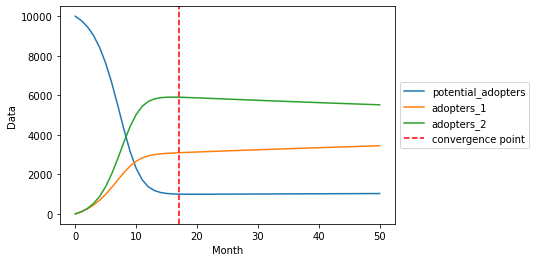

In [5]:
model = pysd.load('./slap_the_bass.py')

values = model.run(return_columns=['potential_adopters', 'adopters_1', 'adopters_2'])
convergence_point, periodic_point = find_convergence_point(values)

values.plot()

if convergence_point != -1:
    plt.axline((convergence_point, 0), (convergence_point, 1), color="r", linestyle='--', label='convergence point')
if periodic_point != -1:
        plt.axline((periodic_point, 0), (periodic_point, 1), color="c", linestyle='-', label='periodic point')

plt.ylabel('Data')
plt.xlabel('Month')
plt.legend(loc='center left', bbox_to_anchor=(1,.5));

Приемлемый результат, вроде момент начала стационарного решения найден корректно.

Теперь проверим на множественном запуске и убедимся, что все корректно. Добавим немного рандома и вариации начальных условий. Можно было бы подбирать решения на равномерной или логарифмической сетке, но и рандом с этим неплохо справляется.

Найдено стационарное состояние в точке 39.0


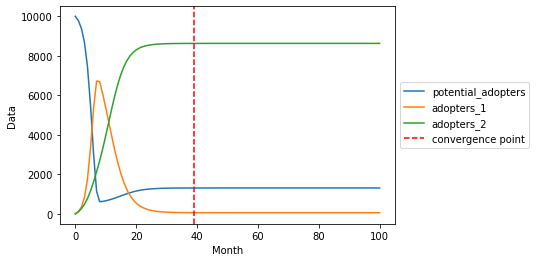

Найдено стационарное состояние в точке 23.0


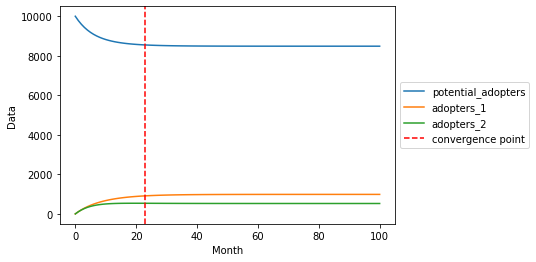

Найдено стационарное состояние в точке 40.0


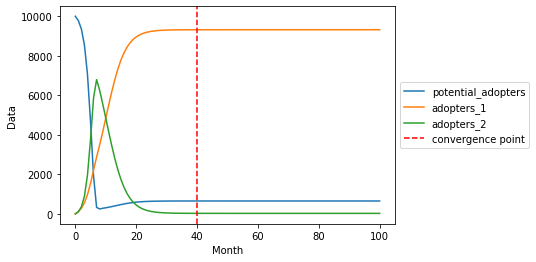

Найдено стационарное состояние в точке 29.0


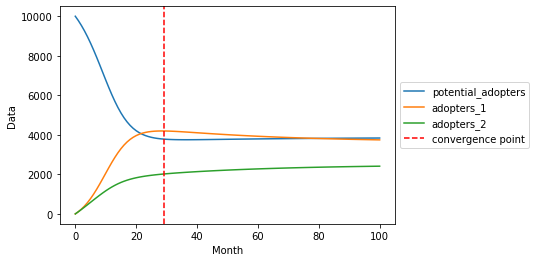

Найдено стационарное состояние в точке 38.0


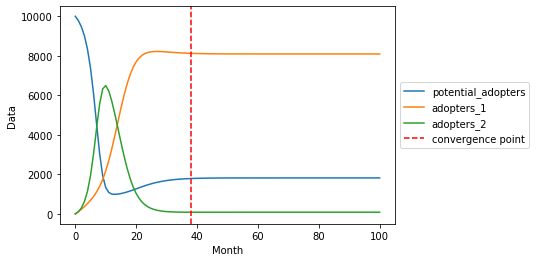

Стационарное состояние не найдено на заданном интервале
Периодическое решение также не найдено на заданном интервале


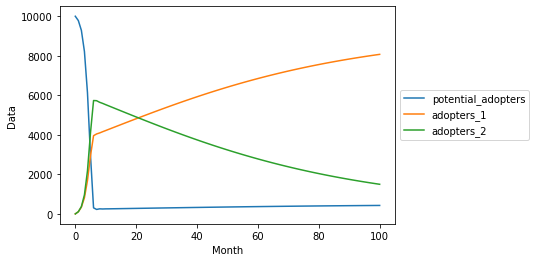

Найдено стационарное состояние в точке 33.0


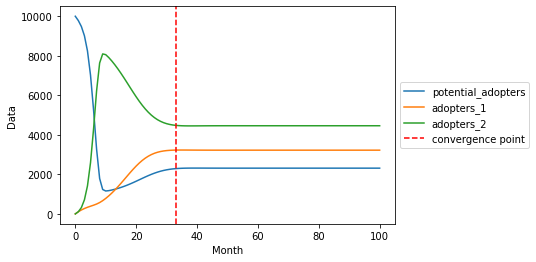

Найдено стационарное состояние в точке 10.0


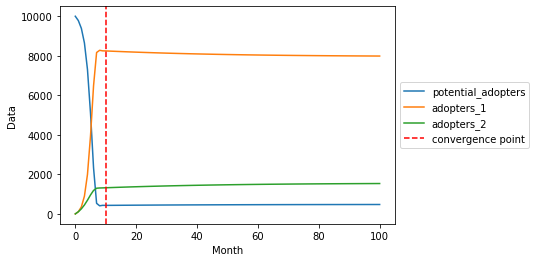

Найдено стационарное состояние в точке 58.0


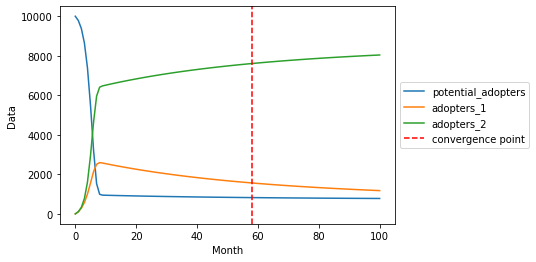

Найдено стационарное состояние в точке 38.0


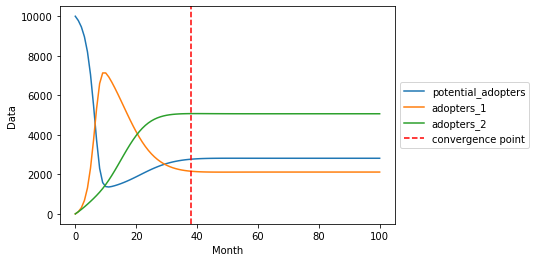

In [6]:
for i in range(10):

    model = pysd.load('./slap_the_bass.py')
    #     P11 
    chaotic_rate_1 = random.randrange(0, 1e+7) * 1e-7
    #     P13 
    neutral_rate_1 = random.randrange(0, int((1-chaotic_rate_1) * 1e+7)) * 1e-7
    #     P21 
    chaotic_rate_2 = random.randrange(0, 1e+7) * 1e-7
    #     P23 
    neutral_rate_2 = random.randrange(0, int((1-chaotic_rate_2) * 1e+7)) * 1e-7

    values = model.run(params=
                       {
                        'chaotic_rate_1':chaotic_rate_1,
                        'neutral_rate_1':neutral_rate_1,
                        'chaotic_rate_2':chaotic_rate_2,
                        'neutral_rate_2':neutral_rate_2,
                           'time_step': 1,
                           'final_time': 100
                       },return_columns=['potential_adopters', 'adopters_1', 'adopters_2'])

    convergence_point, periodic_point = find_convergence_point(values)
    values.plot()
    if convergence_point != -1:
        plt.axline((convergence_point, 0), (convergence_point, 1), color="r", linestyle='--', label='convergence point')
        
    if periodic_point != -1:
        plt.axline((periodic_point, 0), (periodic_point, 1), color="c", linestyle='-.', 
                   label='periodic point')
    plt.ylabel('Data')
    plt.xlabel('Month')
    plt.legend(loc='center left', bbox_to_anchor=(1,.5))
    plt.show()

Вроде не так все плохо.

А вот теперь сложный этап. Честно говоря, сколько я не пытался симулировать, но нестационарное решение у меня не получилось найти при заданном ограничении. И никакие логарифмические и равномерные сетки и изменение параметров в процессе моделирования не выводили систему из равновесия, все равно система приходила к какому-то балансу. Однако, за пределами ограничений существуют совершенно разные решения. Есть один финт ушами, который покажу, но это скорее баг питона, и в anylogic таких проблем не должно наблюдаться. 

Сейчас мы найдем некоторые параметры $P_{11}, P_{21}, P_{13}, P_{23}$. И будем варьировать длину одного шага, чтобы найти некоторое нестационарное решение. Вот только таким образом удалось найти что-то нестационарное.

Найдено стационарное состояние в точке 122.5


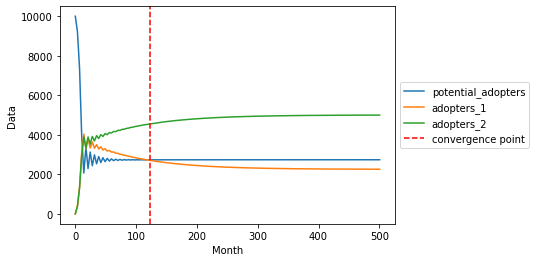

Найдено стационарное состояние в точке 227.05555555555557


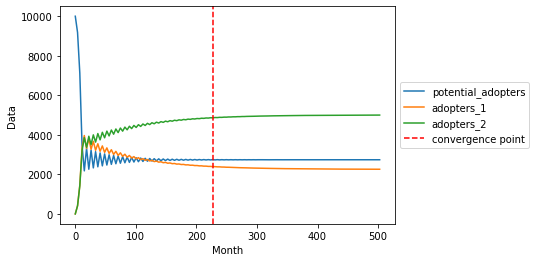

Стационарное состояние не найдено на заданном интервале
Найдено периодическое решение начиная с точки 343.17


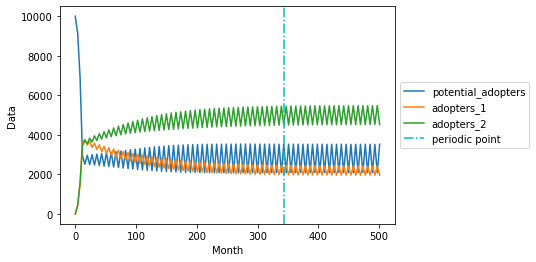

Стационарное состояние не найдено на заданном интервале
Найдено периодическое решение начиная с точки 333.33


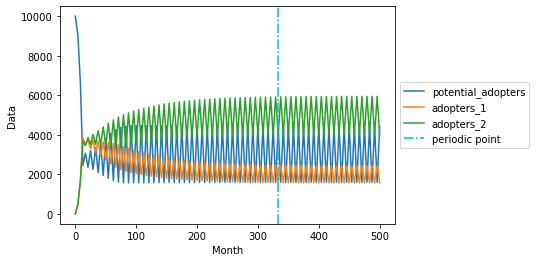

Стационарное состояние не найдено на заданном интервале
Найдено периодическое решение начиная с точки 324.78


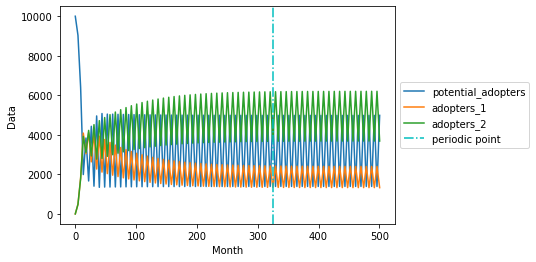

Стационарное состояние не найдено на заданном интервале
Найдено периодическое решение начиная с точки 318.17


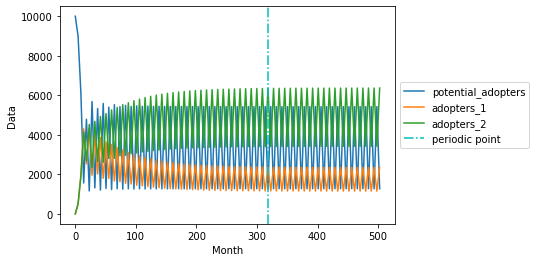

Стационарное состояние не найдено на заданном интервале
Найдено периодическое решение начиная с точки 309.33


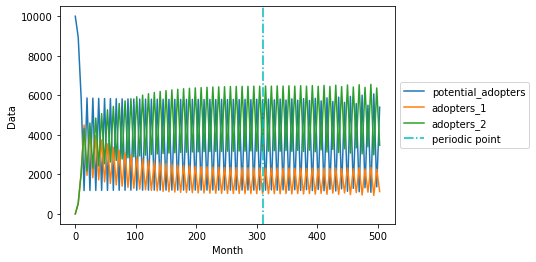

Стационарное состояние не найдено на заданном интервале
Найдено периодическое решение начиная с точки 298.28


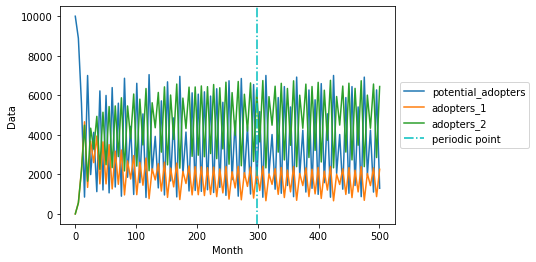

Стационарное состояние не найдено на заданном интервале
Найдено периодическое решение начиная с точки 253.33


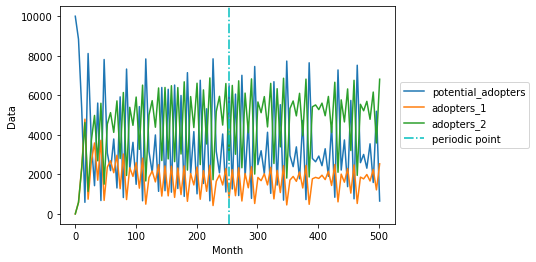

Стационарное состояние не найдено на заданном интервале
Периодическое решение также не найдено на заданном интервале


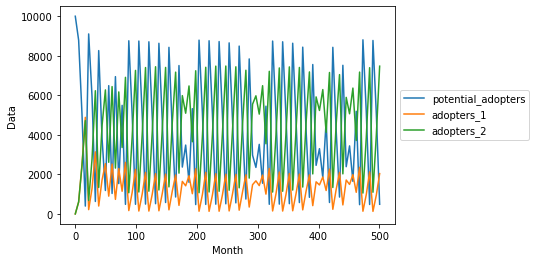

In [7]:
time_steps = np.linspace(3.5, 5.5, 10) 

for i in range(len(time_steps)):

    model = pysd.load('./slap_the_bass.py')

    values = model.run(params=
                       {
                         'chaotic_rate_1':0.46,
                        'neutral_rate_1':0.46,
                        'chaotic_rate_2':0.44,
                        'neutral_rate_2':0.45,
                           'time_step': time_steps[i],
                           'final_time': 500
                       },return_columns=['potential_adopters', 'adopters_1', 'adopters_2'])
    
    convergence_point, periodic_point = find_convergence_point(values)
    values.plot()
    if convergence_point != -1:
        plt.axline((convergence_point, 0), (convergence_point, 1), color="r", linestyle='--', label='convergence point')
    if periodic_point != -1:
        plt.axline((periodic_point, 0), (periodic_point, 1), color="c", linestyle='-.', 
                   label='periodic point')
    plt.ylabel('Data')
    plt.xlabel('Month')
    plt.legend(loc='center left', bbox_to_anchor=(1,.5))
    plt.show()

В целом работает, но не ловит сложные периодические решения. Если увеличивать дальше размер шага, то вообще все ломается и показатели выходят из зоны допустимых значений.

Это в принципе все, что у меня получилось. Не так много. Таким образом из реализованного это сама модифицированная модель (надеюсь, что корректная). Кое-какой алгоритм определения сходимости и нахождения различных решений. Наверное, алгоритм работал более корректно, если мне удалось бы найти нестационарное решение в рамках, установленных ограничениями.

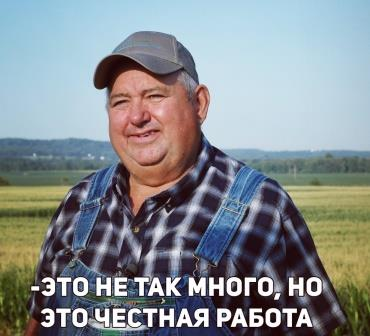